In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import torchvision 
from sklearn.model_selection import train_test_split 
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torchvision import datasets, transforms
import torch 
from pathlib import Path
import pathlib
import seaborn as sns 

# Is the dataset balanced?


In [7]:
root = r'C:\Users\USER\Desktop\New_task\flowers-recognition\flowers'
daisy = Path(root)/'daisy'
dandelion = Path(root)/'dandelion'
rose = Path(root)/'rose'
sunflower = Path(root)/'sunflower'
tulip = Path(root)/'tulip'
paths = [daisy, dandelion, rose, sunflower, tulip]

In [11]:
def count_images(paths):
    ''' 
    Use for count files in each folder
    paths = directory
    '''
    count = []
    for clas in paths:
        c = len(os.listdir(clas))
        count.append(c)
    return count

In [12]:
labels = os.listdir(root)
counts = count_images(paths)

In [16]:
def vizualize_ratios(labels, counts):
    '''Vizualization of ratios in percentage
        labels = List[classes]
        counts = List[counts]
    '''
    colors = sns.color_palette('pastel')[0:5]
    plt.figure(figsize = (10, 10))
    plt.pie(counts, labels = labels, colors = colors, autopct='%.0f%%')
    plt.show()


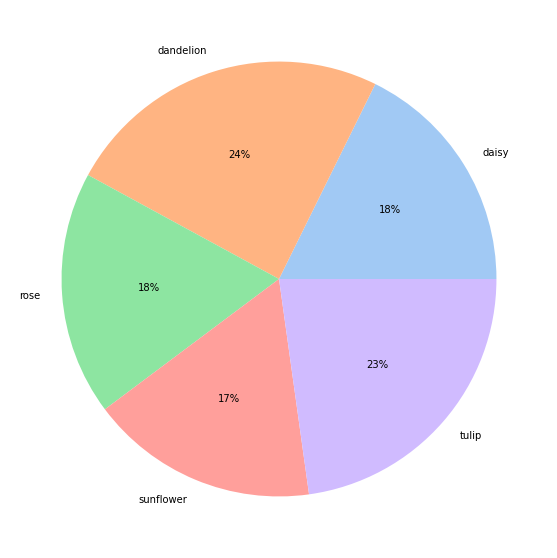

In [17]:
vizualize_ratios(labels, counts)

As we can see the dataset a bit imbalanced but ratios of classes are acceptable. Imbalance ratio is small and we doesnt need to 
apply some oversampling/undersampling techniques. Further, while model training I will show that we can obtain 
good results without changing anything in dataset.

# What features should be involved in a train-test split decision? Should you use a stratification for that?

Since dataset is small and comparably balanced, we will use all images for modeling.
We can use train/test split using stratified sampling. Ratios of train/test are 80/20

Lets check the ratios of classes in train/test

Firstly, lets create PyTorch Dataset

In [18]:
def read_dataset(root, size):
    
    '''
    Read, transform and create ImageFolder dataset:
    root = directory
    size = image size for transform
    '''
    flower_transform = transforms.Compose([transforms.Resize((size, size)),
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    flower_dataset = datasets.ImageFolder(root, transform=flower_transform)
    return flower_dataset 


In [19]:
flower_dataset = read_dataset(root, 224)
flower_dataset.class_to_idx

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

Now, define dictionary which replace key-value pairs (idx to class)

In [20]:
idx2class = {v: k for k, v in flower_dataset.class_to_idx.items()}
idx2class

{0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

In [21]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

For understanding distribution of classes in dataset, lets define following function

In [22]:
print("Distribution of classes: \n", get_class_distribution(flower_dataset))

Distribution of classes: 
 {'daisy': 764, 'dandelion': 1052, 'rose': 784, 'sunflower': 733, 'tulip': 984}


Dataset is small comparably to famous dataset such as CIFAR10 or MNIST. However, it's not so so small and count thousands images. Cross validation 
computation can be time consuming and costly in this case. 

As we saw in previous step, class distribution isnt balanced. But imbalance level no critical

We can use sklearn's train_test_split, which let us split dataset using stratification 

In [28]:
def train_test_split_with_stratification(flower_dataset):
    targets = flower_dataset.targets

    train_idx, valid_idx= train_test_split(
        np.arange(len(targets)), test_size=0.2, random_state=42, shuffle=True, stratify=targets)
    
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = DataLoader(dataset=flower_dataset, shuffle=False, batch_size=1, sampler=train_sampler)
    val_loader = DataLoader(dataset=flower_dataset, shuffle=False, batch_size=1, sampler=val_sampler)
    
    return train_loader, val_loader

Similarly, we can define function for understanding classes distribution in DataLoaders

In [24]:
train_loader, val_loader = train_test_split_with_stratification(flower_dataset)

In [25]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for _,j in dataloader_obj:
        y_idx = j.item()
        y_lbl = idx2class[y_idx]
        count_dict[str(y_lbl)] += 1
            
    return count_dict

In [26]:
get_class_distribution_loaders(train_loader, flower_dataset)

{'daisy': 611, 'dandelion': 842, 'rose': 627, 'sunflower': 586, 'tulip': 787}

In [27]:
get_class_distribution_loaders(val_loader, flower_dataset)

{'daisy': 153, 'dandelion': 210, 'rose': 157, 'sunflower': 147, 'tulip': 197}

Ratios in both train and val. sets are the same as in original dataset